In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from keras.callbacks import Callback, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

## Loading Data
Data is loaded from images in the folder *"dataset/"*. There are two classes: *"true"* specifies images with the pedestrian using a smartphone, while *"false"* specifies images with the pedestrian not holding a smartphone. The images are loaded, shuffled and batched.

In [17]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

IMAGE_DIR = "dataset/"
MODEL_NAME = "smato_efficientnet_m2"
SAVE_DIR = f"saved_models/{MODEL_NAME}/"

dataset = tf.keras.utils.image_dataset_from_directory(IMAGE_DIR,
                                                      shuffle = False,
                                                      seed = 141,
                                                      batch_size = None,
                                                      image_size = IMAGE_SIZE)
CLASS_NAMES = dataset.class_names
dataset_size = len(dataset)
dataset = dataset.shuffle(buffer_size = dataset_size, seed = 141, reshuffle_each_iteration = False)
# count images in each category
counts = {
    1: 0,
    0: 0
}
for i in dataset:
    _, cls = i
    counts[int(cls)] += 1
print("Number of pedestrians with a smartphone: ", counts[1])
print("Number of pedestrians without a smartphone: ", counts[0])

# batch the dataset
dataset = dataset.batch(batch_size = BATCH_SIZE)
print("Classes: ", CLASS_NAMES)
print("Total number of batches created: ", len(dataset))

Found 9808 files belonging to 2 classes.
Number of pedestrians with a smartphone:  2640
Number of pedestrians without a smartphone:  7168
Classes:  ['false', 'true']
Total number of batches created:  307


## Splitting Dataset
The dataset is split into training, validation, and test set. 85% of the dataset is reserved for training, while the rest is divided into validation and test dataset in the ratio of 60:40.

In [18]:
# train-validation split
num_batches = len(dataset)
val_dataset = dataset.take(int(num_batches * 0.15))
train_dataset = dataset.skip(int(num_batches * 0.15))

# validation-test split
num_val_batches = len(val_dataset)
test_dataset = val_dataset.take(int(num_val_batches * 0.4))
validation_dataset = val_dataset.skip(int(num_val_batches * 0.4))

In [20]:
print("Number of batches in Training Dataset: ", len(train_dataset))
print("Number of batches in Validation Dataset: ", len(validation_dataset))
print("Number of batches in Test Dataset: ", len(test_dataset))

Number of batches in Training Dataset:  261
Number of batches in Validation Dataset:  28
Number of batches in Test Dataset:  18


In [21]:
# rescale for tf hub - models on tf-hub require pixel values b/w 0 and 1
normalize = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalize(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalize(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalize(x), y))

In [22]:
# buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

## Model Definition
A model is defined using MobileNet-V2 as the feature extractor, followed by three fully connected hidden layers. Batch Normalization is performed after each FC layer, and dropout is used to reduce overfitting.

In [33]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_layer = hub.KerasLayer(
    mobilenet_v2,
    trainable = False)

model = tf.keras.Sequential([
    
    tf.keras.layers.InputLayer(IMAGE_SIZE + (3, )),
    feature_extractor_layer,

    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.6),
    
    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1, activation = "sigmoid")
], name = MODEL_NAME)

model.summary()

Model: "smato_efficientnet_m2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                             

## Metric for choosing best model: F1 Score

In [34]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall)/(precision + recall + K.epsilon())
    return f1_val

## Model Training
While training the model, only the best model is saved. This is decided by the metric accuracy on the validation set

In [35]:
model.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss = tf.keras.losses.BinaryCrossentropy(),
  metrics = ['acc', f1]
)

In [36]:
NUM_EPOCHS = 50

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = SAVE_DIR,
    save_weights_only = False,
    monitor = 'val_f1',
    mode = 'max',
    save_best_only = True
)

history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = NUM_EPOCHS,
                    callbacks = [model_checkpoint_callback])

Epoch 1/50
260/261 [============================>.] - ETA: 0s - loss: 0.6115 - acc: 0.6966 - f1: 0.2698INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 35s 94ms/step - loss: 0.6113 - acc: 0.6969 - f1: 0.2710 - val_loss: 0.4947 - val_acc: 0.7868 - val_f1: 0.4614
Epoch 2/50
259/261 [============================>.] - ETA: 0s - loss: 0.5304 - acc: 0.7451 - f1: 0.2841INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 33s 93ms/step - loss: 0.5302 - acc: 0.7451 - f1: 0.2846 - val_loss: 0.4551 - val_acc: 0.7991 - val_f1: 0.4733
Epoch 3/50
259/261 [============================>.] - ETA: 0s - loss: 0.4893 - acc: 0.7576 - f1: 0.3248INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 34s 97ms/step - loss: 0.4890 - acc: 0.7577 - f1: 0.3243 - val_loss: 0.4223 - val_acc: 0.8114 - val_f1: 0.5408
Epoch 4/50
260/261 [============================>.] - ETA: 0s - loss: 0.4612 - acc: 0.7748 - f1: 0.3910INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 35s 98ms/step - loss: 0.4612 - acc: 0.7747 - f1: 0.3895 - val_loss: 0.4137 - val_acc: 0.8248 - val_f1: 0.6356
Epoch 5/50
261/261 [==============================] - 32s 85ms/step - loss: 0.4401 - acc: 0.7776 - f1: 0.4187 - val_loss: 0.3848 - val_acc: 0.8225 - val_f1: 0.5996
Epoch 6/50
259/261 [============================>.] - ETA: 0s - loss: 0.4058 - acc: 0.7893 - f1: 0.4603INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 36s 102ms/step - loss: 0.4056 - acc: 0.7893 - f1: 0.4603 - val_loss: 0.3637 - val_acc: 0.8415 - val_f1: 0.6733
Epoch 7/50
260/261 [============================>.] - ETA: 0s - loss: 0.3938 - acc: 0.7910 - f1: 0.4785INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 37s 103ms/step - loss: 0.3937 - acc: 0.7910 - f1: 0.4782 - val_loss: 0.3609 - val_acc: 0.8438 - val_f1: 0.7193
Epoch 8/50
259/261 [============================>.] - ETA: 0s - loss: 0.3754 - acc: 0.7961 - f1: 0.5044INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 38s 106ms/step - loss: 0.3748 - acc: 0.7963 - f1: 0.5059 - val_loss: 0.3444 - val_acc: 0.8449 - val_f1: 0.7282
Epoch 9/50
261/261 [==============================] - 35s 94ms/step - loss: 0.3497 - acc: 0.8118 - f1: 0.5507 - val_loss: 0.3350 - val_acc: 0.8527 - val_f1: 0.7238
Epoch 10/50
259/261 [============================>.] - ETA: 0s - loss: 0.3406 - acc: 0.8067 - f1: 0.5361INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 38s 106ms/step - loss: 0.3405 - acc: 0.8069 - f1: 0.5374 - val_loss: 0.3281 - val_acc: 0.8516 - val_f1: 0.7561
Epoch 11/50
259/261 [============================>.] - ETA: 0s - loss: 0.3308 - acc: 0.8119 - f1: 0.5547INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 39s 107ms/step - loss: 0.3305 - acc: 0.8117 - f1: 0.5549 - val_loss: 0.3107 - val_acc: 0.8705 - val_f1: 0.7672
Epoch 12/50
261/261 [==============================] - 36s 94ms/step - loss: 0.3157 - acc: 0.8688 - f1: 0.7414 - val_loss: 0.3123 - val_acc: 0.8571 - val_f1: 0.7521
Epoch 13/50
259/261 [============================>.] - ETA: 0s - loss: 0.2945 - acc: 0.8839 - f1: 0.7793INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 39s 107ms/step - loss: 0.2950 - acc: 0.8836 - f1: 0.7787 - val_loss: 0.3038 - val_acc: 0.8862 - val_f1: 0.7716
Epoch 14/50
261/261 [==============================] - ETA: 0s - loss: 0.2838 - acc: 0.8863 - f1: 0.7817INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 40s 111ms/step - loss: 0.2838 - acc: 0.8863 - f1: 0.7817 - val_loss: 0.2878 - val_acc: 0.8839 - val_f1: 0.7827
Epoch 15/50
259/261 [============================>.] - ETA: 0s - loss: 0.2817 - acc: 0.8932 - f1: 0.7973INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 40s 109ms/step - loss: 0.2813 - acc: 0.8934 - f1: 0.7982 - val_loss: 0.2801 - val_acc: 0.8783 - val_f1: 0.7868
Epoch 16/50
259/261 [============================>.] - ETA: 0s - loss: 0.2746 - acc: 0.8932 - f1: 0.7970INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 41s 115ms/step - loss: 0.2743 - acc: 0.8934 - f1: 0.7977 - val_loss: 0.2815 - val_acc: 0.8862 - val_f1: 0.8004
Epoch 17/50
260/261 [============================>.] - ETA: 0s - loss: 0.2623 - acc: 0.8970 - f1: 0.8052INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 41s 110ms/step - loss: 0.2622 - acc: 0.8971 - f1: 0.8055 - val_loss: 0.2894 - val_acc: 0.9007 - val_f1: 0.8119
Epoch 18/50
261/261 [==============================] - 37s 99ms/step - loss: 0.2487 - acc: 0.9086 - f1: 0.8253 - val_loss: 0.3006 - val_acc: 0.8527 - val_f1: 0.7684
Epoch 19/50
260/261 [============================>.] - ETA: 0s - loss: 0.2390 - acc: 0.9132 - f1: 0.8343INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 41s 114ms/step - loss: 0.2390 - acc: 0.9131 - f1: 0.8340 - val_loss: 0.2618 - val_acc: 0.9085 - val_f1: 0.8342
Epoch 20/50
261/261 [==============================] - 38s 101ms/step - loss: 0.2303 - acc: 0.9142 - f1: 0.8379 - val_loss: 0.2858 - val_acc: 0.9029 - val_f1: 0.8063
Epoch 21/50
261/261 [==============================] - 38s 100ms/step - loss: 0.2245 - acc: 0.9124 - f1: 0.8353 - val_loss: 0.2899 - val_acc: 0.8962 - val_f1: 0.7974
Epoch 22/50
261/261 [==============================] - ETA: 0s - loss: 0.2151 - acc: 0.9223 - f1: 0.8508INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 42s 115ms/step - loss: 0.2151 - acc: 0.9223 - f1: 0.8508 - val_loss: 0.2581 - val_acc: 0.9118 - val_f1: 0.8363
Epoch 23/50
261/261 [==============================] - 38s 101ms/step - loss: 0.2097 - acc: 0.9249 - f1: 0.8566 - val_loss: 0.2494 - val_acc: 0.9107 - val_f1: 0.8357
Epoch 24/50
261/261 [==============================] - 39s 103ms/step - loss: 0.1950 - acc: 0.9341 - f1: 0.8742 - val_loss: 0.2775 - val_acc: 0.9085 - val_f1: 0.8214
Epoch 25/50
261/261 [==============================] - 39s 102ms/step - loss: 0.2026 - acc: 0.9292 - f1: 0.8643 - val_loss: 0.2677 - val_acc: 0.9074 - val_f1: 0.8245
Epoch 26/50
261/261 [==============================] - 39s 103ms/step - loss: 0.1934 - acc: 0.9333 - f1: 0.8740 - val_loss: 0.3091 - val_acc: 0.9040 - val_f1: 0.8051
Epoch 27/50
259/261 [============================>.] - ETA: 0s - loss: 0.1811 - acc: 0.9406 - f1: 0.8837INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 43s 118ms/step - loss: 0.1812 - acc: 0.9405 - f1: 0.8836 - val_loss: 0.2378 - val_acc: 0.9107 - val_f1: 0.8425
Epoch 28/50
261/261 [==============================] - 39s 104ms/step - loss: 0.1732 - acc: 0.9407 - f1: 0.8840 - val_loss: 0.2634 - val_acc: 0.9018 - val_f1: 0.8261
Epoch 29/50
261/261 [==============================] - 39s 104ms/step - loss: 0.1764 - acc: 0.9374 - f1: 0.8784 - val_loss: 0.2679 - val_acc: 0.9085 - val_f1: 0.8362
Epoch 30/50
261/261 [==============================] - 40s 105ms/step - loss: 0.1682 - acc: 0.9419 - f1: 0.8874 - val_loss: 0.2769 - val_acc: 0.9129 - val_f1: 0.8323
Epoch 31/50
261/261 [==============================] - 40s 106ms/step - loss: 0.1699 - acc: 0.9433 - f1: 0.8906 - val_loss: 0.2527 - val_acc: 0.9051 - val_f1: 0.8349
Epoch 32/50
260/261 [============================>.] - ETA: 0s - loss: 0.1590 - acc: 0.9493 - f1: 0.9009INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 44s 120ms/step - loss: 0.1590 - acc: 0.9493 - f1: 0.9009 - val_loss: 0.2411 - val_acc: 0.9074 - val_f1: 0.8426
Epoch 33/50
261/261 [==============================] - 40s 104ms/step - loss: 0.1684 - acc: 0.9500 - f1: 0.9022 - val_loss: 0.2718 - val_acc: 0.9152 - val_f1: 0.8307
Epoch 34/50
260/261 [============================>.] - ETA: 0s - loss: 0.1519 - acc: 0.9502 - f1: 0.9017INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 44s 123ms/step - loss: 0.1518 - acc: 0.9503 - f1: 0.9021 - val_loss: 0.2164 - val_acc: 0.9252 - val_f1: 0.8649
Epoch 35/50
261/261 [==============================] - 40s 106ms/step - loss: 0.1380 - acc: 0.9545 - f1: 0.9100 - val_loss: 0.2350 - val_acc: 0.9230 - val_f1: 0.8537
Epoch 36/50
261/261 [==============================] - 41s 108ms/step - loss: 0.1515 - acc: 0.9500 - f1: 0.9010 - val_loss: 0.2423 - val_acc: 0.9241 - val_f1: 0.8607
Epoch 37/50
261/261 [==============================] - 40s 107ms/step - loss: 0.1326 - acc: 0.9584 - f1: 0.9176 - val_loss: 0.2419 - val_acc: 0.9230 - val_f1: 0.8584
Epoch 38/50
261/261 [==============================] - 41s 108ms/step - loss: 0.1381 - acc: 0.9509 - f1: 0.9040 - val_loss: 0.2388 - val_acc: 0.9185 - val_f1: 0.8534
Epoch 39/50
261/261 [==============================] - 41s 109ms/step - loss: 0.1438 - acc: 0.9533 - f1: 0.9077 - val_loss: 0.2879 - val_acc: 0.9196 - val_f1: 0.8418
Epoch 40/50
259/

INFO:tensorflow:Assets written to: saved_models/smato_efficientnet_m2\assets


261/261 [==============================] - 44s 121ms/step - loss: 0.1230 - acc: 0.9625 - f1: 0.9247 - val_loss: 0.2255 - val_acc: 0.9330 - val_f1: 0.8790
Epoch 41/50
261/261 [==============================] - 41s 107ms/step - loss: 0.1318 - acc: 0.9596 - f1: 0.9200 - val_loss: 0.2361 - val_acc: 0.9174 - val_f1: 0.8462
Epoch 42/50
261/261 [==============================] - 41s 108ms/step - loss: 0.1171 - acc: 0.9633 - f1: 0.9278 - val_loss: 0.2953 - val_acc: 0.9152 - val_f1: 0.8335
Epoch 43/50
261/261 [==============================] - 41s 107ms/step - loss: 0.1284 - acc: 0.9598 - f1: 0.9189 - val_loss: 0.2505 - val_acc: 0.9196 - val_f1: 0.8433
Epoch 44/50
261/261 [==============================] - 40s 107ms/step - loss: 0.1200 - acc: 0.9632 - f1: 0.9289 - val_loss: 0.2353 - val_acc: 0.9263 - val_f1: 0.8583
Epoch 45/50
261/261 [==============================] - 41s 108ms/step - loss: 0.1220 - acc: 0.9616 - f1: 0.9240 - val_loss: 0.2037 - val_acc: 0.9263 - val_f1: 0.8683
Epoch 46/50
261/

## Model Evaluation
The best trained model is loaded and the test dataset is used for evaluating performance on data never been used in this process.

In [39]:
model = keras.models.load_model(SAVE_DIR, custom_objects = {"f1": f1})
model.evaluate(test_dataset)

18/18 [==============================] - 20s 470ms/step - loss: 0.2398 - acc: 0.9149 - f1: 0.8478


[0.23976820707321167, 0.9149305820465088, 0.8477843999862671]

## Example Images
A bunch of images from the test dataset are chosen to show the performance of the model and to understand the reasons for misclassification.

Predictions:
 [0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Labels:
 [0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]


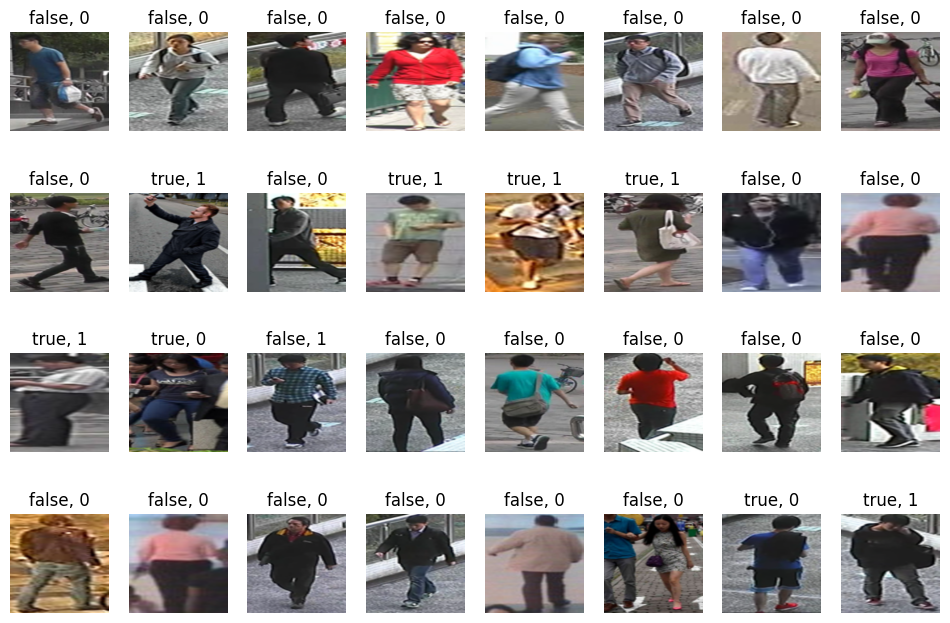

In [41]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.shuffle(10, seed = None).take(1).as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 8))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i])
    plt.title(str(CLASS_NAMES[predictions[i]]) + ", " + str(label_batch[i]))
    plt.axis("off")